Link del dataset: https://www.kaggle.com/datasets/obnifqmv1/reviews-amazon

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# TÉNICA DE TOPIC MODELLING

Obtendremos los tópicos de un conjunto de opiniones extraídas, usando para ello **la librería de Python Gensim.** Gensim es una librería usada para hacer topic modeling. Dentro de esta funcionalidad vienen incluidos una gran variedad de algoritmos que permiten crear este tipo de soluciones. Además de esto, viene con distintos corpus.

El algoritmo que utilizaremos es el modelo **latent dirichlet allocation (LDA)**, que nos devuelve por un lado los diferentes tópicos que componen la colección de documentos y por otro lado cuánto de cada tópico está presente en cada documento.

Los tópicos consisten en una **distribución de probabilidades** de aparición de las distintas palabras del vocabulario.

También usaremos otra librería, que es **pyLADvis**. Se trata de una librería de visualización para topic modeling.

In [ ]:
!pip install pyLDAvis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Importación de librerías

In [ ]:
import pandas as pd
import numpy as np

import re
import string

import spacy

import gensim
from gensim import corpora

# libraries for visualization
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

2023-05-30 17:03:48.259755: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-30 17:03:51.281590: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# DATA
En la información que aparece podemos observar que son reviews o reseñas de Amazón. Visualizamos información acerca de la tabla

In [ ]:
review_data= pd.read_csv("Reviews.csv")
print(review_data.head(2))
print(len(review_data))
print('Unique Products')
print(len(review_data.groupby('ProductId')))
print('Unique Users')
print(len(review_data.groupby('UserId')))

   Id   ProductId          UserId ProfileName  HelpfulnessNumerator  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW  delmartian                     1   
1   2  B00813GRG4  A1D87F6ZCVE5NK      dll pa                     0   

   HelpfulnessDenominator  Score        Time                Summary  \
0                       1      5  1303862400  Good Quality Dog Food   
1                       0      1  1346976000      Not as Advertised   

                                                Text  
0  I have bought several of the Vitality canned d...  
1  Product arrived labeled as Jumbo Salted Peanut...  
568454
Unique Products
74258
Unique Users
256059


# Limpieza inicial del texto
Eliminamos puntuaciones y caracteres innecesarios.

In [ ]:
def clean_text(text ): 
    delete_dict = {sp_character: '' for sp_character in string.punctuation} 
    delete_dict[' '] = ' ' 
    table = str.maketrans(delete_dict)
    text1 = text.translate(table)
    #print('cleaned:'+text1)
    textArr= text1.split()
    text2 = ' '.join([w for w in textArr if ( not w.isdigit() and  ( not w.isdigit() and len(w)>3))]) 
    
    return text2.lower()

In [ ]:
import nltk
nltk.download('stopwords') # run this one time

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

**Implementamos un método que se encarga de realizar la limpieza inicial de los textos**

In [ ]:
review_data.dropna(axis = 0, how ='any',inplace=True) 

review_data['Text'] = review_data['Text'].apply(clean_text)
review_data['Num_words_text'] = review_data['Text'].apply(lambda x:len(str(x).split())) 

print('-------Dataset --------')
print(review_data['Score'].value_counts())
print(len(review_data))
print('-------------------------')
max_review_data_sentence_length  = review_data['Num_words_text'].max()

mask = (review_data['Num_words_text'] < 100) & (review_data['Num_words_text'] >=20)
df_short_reviews = review_data[mask]
df_sampled = df_short_reviews.groupby('Score').apply(lambda x: x.sample(n=20000)).reset_index(drop = True)

print('No of Short reviews')
print(len(df_short_reviews))

#all_sentences = train_data['text'].tolist() + test_data['text'].tolist()

-------Dataset --------
Score
5    363102
4     80654
1     52264
3     42638
2     29743
Name: count, dtype: int64
568401
-------------------------
No of Short reviews
373279


# Eliminamos las stopwords
Las palabras comunes que no aportan significado, como yo, el o y.

In [ ]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
# function to remove stopwords
def remove_stopwords(text):
    textArr = text.split(' ')
    rem_text = " ".join([i for i in textArr if i not in stop_words])
    return rem_text

# remove stopwords from the text
df_sampled['Text']=df_sampled['Text'].apply(remove_stopwords)

In [ ]:
pip install -U spacy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import spacy.cli

In [ ]:
spacy.cli.download("en_core_web_md")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 16.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


# Preprocesamiento de los datos
Técnica de normalización de texto: **lematización.**
La lemmatización es un poco más compleja e implica hacer un análisis del vocabulario y su morfología para retornar la forma básica de la palabra. El principal objetivo de esta técnica es reducir el número de palabras únicas en un documento de texto, haciendo más sencillo el proceso de análisis.

In [ ]:
nlp = spacy.load('en_core_web_md', disable=['parser', 'ner'])

def lemmatization(texts,allowed_postags=['NOUN', 'ADJ']): 
       output = []
       for sent in texts:
             doc = nlp(sent) 
             output.append([token.lemma_ for token in doc if token.pos_ in allowed_postags ])
       return output

In [ ]:
text_list=df_sampled['Text'].tolist()
print(text_list[1])
tokenized_reviews = lemmatization(text_list)
print(tokenized_reviews[1])

purchased bags dogfood week feeding newman brand started vomiting eating time lied around whimpering stomach ache checked stomach disorder took newman dogfood symptoms disappearedbr sent three emails newman dogfood website replies acknowledgement phone number available dogfood expensive customer service existent
['bag', 'dogfood', 'week', 'feeding', 'newman', 'time', 'stomach', 'ache', 'stomach', 'disorder', 'newman', 'dogfood', 'symptom', 'disappearedbr', 'email', 'newman', 'dogfood', 'website', 'phone', 'number', 'available', 'dogfood', 'expensive', 'customer', 'service', 'existent']


# Generación del diccionario y corpus, principales entradas del modelo LDA
Los **diccionarios** son objetos que asignan un identificador numérico a cada palabra única y se pueden usar para obtener el identificador a partir de la palabra y viceversa.

La generación de estos diccionarios con la librería Gensim es tan fácil como crear un objeto de tipo **Dictionary** pasándole como argumento las listas de palabras.

En nuestro caso y como vimos en el anterior post, tenemos almacenadas las listas de palabras, pertenecientes al conjunto de opiniones, en la columna tokenized_reviews de nuestro objeto DataFrame.

In [ ]:
dictionary = corpora.Dictionary(tokenized_reviews)
doc_term_matrix = [dictionary.doc2bow(rev) for rev in tokenized_reviews]

# Construyendo el modelo LDA
Para ello creamos un objeto LDA de la librería Gensim pasándole como argumento el corpus y el diccionario y le indicamos adicionalmente los siguientes parámetros:

*   **doc_term_matrix:** convierte un objeto de la clase 'logtermmatrix' del paquete en una matrix dispersa
*   **num_topics:** número de tópicos. Extraremos 10 tópicos.
*   **random_state:** parámetro para controlar la aleatoriedad del proceso de entrenamiento y que nos devuelva siempre los mismos resultados.
*   **chunksize:** número de documentos que será utilizado en cada pasada de entrenamiento.
*   **passes:** número de pasadas por el corpus durante el entrenamiento.

In [ ]:
# Creating the object for LDA model using gensim library
LDA = gensim.models.ldamodel.LdaModel

# Build LDA model
lda_model = LDA(corpus=doc_term_matrix, id2word=dictionary, num_topics=10, random_state=100,
                chunksize=1000, passes=50,iterations=100)

Para visualizar los tópicos extraídos podemos utilizar la función **print_topics** indicándole el número de tópicos y el número de palabras por tópico que queremos que se muestre.

Por cada tópico podemos ver las cinco palabras que más contribuyen a ese tópico y sus pesos en el mismo. El peso nos indica como de importante es la palabra en ese tópico.

In [ ]:
lda_model.print_topics()

[(0,
  '0.051*"flavor" + 0.042*"good" + 0.029*"taste" + 0.026*"cookie" + 0.020*"great" + 0.019*"little" + 0.017*"butter" + 0.015*"peanut" + 0.013*"love" + 0.012*"sweet"'),
 (1,
  '0.032*"popcorn" + 0.023*"thank" + 0.018*"time" + 0.017*"instant" + 0.016*"date" + 0.015*"easy" + 0.013*"moist" + 0.012*"door" + 0.012*"shipment" + 0.011*"strawberry"'),
 (2,
  '0.037*"product" + 0.036*"price" + 0.035*"store" + 0.032*"amazon" + 0.031*"good" + 0.028*"great" + 0.019*"time" + 0.016*"order" + 0.015*"local" + 0.013*"year"'),
 (3,
  '0.078*"chocolate" + 0.056*"chip" + 0.044*"snack" + 0.029*"sweet" + 0.028*"flavor" + 0.027*"bar" + 0.022*"good" + 0.022*"great" + 0.019*"potato" + 0.018*"taste"'),
 (4,
  '0.050*"sauce" + 0.025*"cheese" + 0.023*"pasta" + 0.018*"ounce" + 0.018*"ginger" + 0.017*"lemon" + 0.016*"minute" + 0.014*"chicken" + 0.014*"olive" + 0.014*"meal"'),
 (5,
  '0.042*"coconut" + 0.027*"fruit" + 0.020*"juice" + 0.019*"hair" + 0.018*"product" + 0.017*"cherry" + 0.017*"apple" + 0.017*"subscri

# Evaluación del Modelo


*   **Perplexity:** cuanto menor sea este rango, mejor el resultado del  entrenamiento es.
*   **Coherence Score:** mide cuán similares son estas palabras entre sí.



In [ ]:
print('\nPerplexity: ', lda_model.log_perplexity(doc_term_matrix,total_docs=10000))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
from gensim.models.coherencemodel import CoherenceModel
coherence_model_lda = CoherenceModel(model=lda_model, texts=tokenized_reviews, dictionary=dictionary , coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.811433062447957

Coherence Score:  0.4130981967304426


In [ ]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [ ]:
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=doc_term_matrix, texts=tokenized_reviews, start=2, limit=50, step=1)


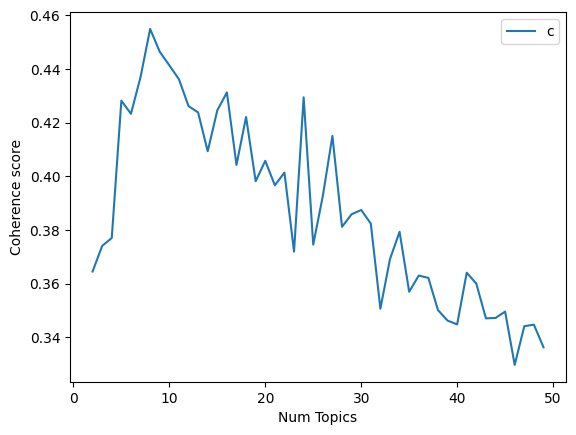

In [ ]:
# Show graph
limit=50; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()# Print the coherence scores

# Distribución de tópicos en el documento
Volumen y distribución de los distintos tópicos que aparecen en el documento.

In [ ]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.3645
Num Topics = 3  has Coherence Value of 0.3741
Num Topics = 4  has Coherence Value of 0.377
Num Topics = 5  has Coherence Value of 0.4282
Num Topics = 6  has Coherence Value of 0.4233
Num Topics = 7  has Coherence Value of 0.437
Num Topics = 8  has Coherence Value of 0.4549
Num Topics = 9  has Coherence Value of 0.4464
Num Topics = 10  has Coherence Value of 0.4414
Num Topics = 11  has Coherence Value of 0.4362
Num Topics = 12  has Coherence Value of 0.4262
Num Topics = 13  has Coherence Value of 0.4238
Num Topics = 14  has Coherence Value of 0.4093
Num Topics = 15  has Coherence Value of 0.4246
Num Topics = 16  has Coherence Value of 0.4313
Num Topics = 17  has Coherence Value of 0.4043
Num Topics = 18  has Coherence Value of 0.4221
Num Topics = 19  has Coherence Value of 0.3982
Num Topics = 20  has Coherence Value of 0.4058
Num Topics = 21  has Coherence Value of 0.3967
Num Topics = 22  has Coherence Value of 0.4014
Num Topics = 23  has Co

In [ ]:
# Select the model and print the topics
optimal_model = model_list[7]
model_topics = optimal_model.show_topics(formatted=False)
optimal_model.print_topics(num_words=10)

[(0,
  '0.041*"water" + 0.023*"drink" + 0.019*"taste" + 0.018*"good" + 0.018*"great" + 0.016*"coconut" + 0.015*"bottle" + 0.013*"product" + 0.013*"energy" + 0.011*"juice"'),
 (1,
  '0.035*"good" + 0.028*"great" + 0.028*"snack" + 0.025*"chip" + 0.020*"taste" + 0.018*"flavor" + 0.017*"salt" + 0.015*"butter" + 0.015*"healthy" + 0.014*"peanut"'),
 (2,
  '0.079*"flavor" + 0.029*"good" + 0.028*"taste" + 0.016*"love" + 0.015*"green" + 0.015*"vanilla" + 0.014*"favorite" + 0.014*"tea" + 0.013*"sweet" + 0.012*"strong"'),
 (3,
  '0.052*"chocolate" + 0.023*"good" + 0.022*"sugar" + 0.020*"fruit" + 0.019*"bar" + 0.017*"sweet" + 0.016*"flavor" + 0.016*"product" + 0.014*"milk" + 0.012*"taste"'),
 (4,
  '0.077*"food" + 0.031*"treat" + 0.023*"dog" + 0.015*"cat" + 0.015*"good" + 0.014*"time" + 0.013*"product" + 0.012*"year" + 0.012*"great" + 0.010*"small"'),
 (5,
  '0.067*"organic" + 0.030*"product" + 0.021*"protein" + 0.020*"fiber" + 0.017*"pill" + 0.016*"ingredient" + 0.016*"honey" + 0.015*"subscribe" 

# Visualización topics-keywords
Cada burbuja que aparece en la zona izquierda representa un tópico diferente. Cuanto mayor sea la burbuja, mayor la prevalencia del tópico.

In [ ]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(optimal_model, doc_term_matrix, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7      0.039951 -0.189322       1        1  17.621016
1     -0.049507  0.019898       2        1  13.759209
4      0.098935 -0.184198       3        1  13.372734
6     -0.139932  0.047071       4        1  11.745164
0     -0.057797 -0.015605       5        1  10.743270
3     -0.020769  0.117489       6        1  10.070829
2     -0.153971  0.143110       7        1  10.043038
8     -0.055948 -0.091299       8        1   7.957453
5      0.339039  0.152856       9        1   4.687287, topic_info=           Term          Freq         Total Category  logprob  loglift
197      coffee  30706.000000  30706.000000  Default  30.0000  30.0000
13         food  23273.000000  23273.000000  Default  29.0000  29.0000
96       flavor  32079.000000  32079.000000  Default  28.0000  28.0000
158   chocolate  11229.000000  11229.000000  Default  27.0000  27.0000
194      amazon  13683.000000  13683.000000  Default  26.0000  26.0000
...         ...           ...           ...      ...      ...      ...
592      powder    567.370764   2397.560252   Topic9  -5.1078   1.6191
3411      spoon    439.860846    659.842801   Topic9  -5.3623   2.6548
65         good    761.039126  46739.681129   Topic9  -4.8141  -1.0573
163       great    605.125085  33283.025056   Topic9  -5.0433  -0.9471
814        high    474.616756   5265.469969   Topic9  -5.2863   0.6539

[649 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
1926      4  0.986584     acidic
1926      5  0.011179     acidic
5505      3  0.998134  addictive
1857      4  0.002023   additive
1857      6  0.997428   additive
...     ...       ...        ...
437       9  0.993869      yeast
1290      1  0.001263     yogurt
1290      3  0.030309     yogurt
1290      6  0.967368     yogurt
4813      4  0.996233       zuke

[1712 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 2, 5, 7, 1, 4, 3, 9, 6])